In [2]:
# Dataset Demographics Analysis
# This notebook analyzes demographics and sequence characteristics of the tokenized EHR dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import glob
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)


In [3]:
# CONFIGURATION - Update these paths for your dataset
MASTER_CSV_PATH = "/data/scratch/qc25022/upgi/master_subject_labels.csv"
TOKENIZED_DATA_ROOT = "/data/scratch/qc25022/upgi/tokenised_data_debug/cprd_test"  # Should contain train/tuning/held_out folders
VOCAB_PATH = "/data/scratch/qc25022/upgi/tokenised_data_debug/cprd_test/vocab.csv"
OUTPUT_DIR = None  # Set to a directory path if you want to save figures

print(f"Master CSV: {MASTER_CSV_PATH}")
print(f"Tokenized Data Root: {TOKENIZED_DATA_ROOT}")
print(f"Vocab Path: {VOCAB_PATH}")


Master CSV: /data/scratch/qc25022/upgi/master_subject_labels.csv
Tokenized Data Root: /data/scratch/qc25022/upgi/tokenised_data_debug/cprd_test
Vocab Path: /data/scratch/qc25022/upgi/tokenised_data_debug/cprd_test/vocab.csv


## 1. Demographics Analysis (from Master CSV)


In [4]:
# Load master CSV
print("Loading master CSV...")
master_df = pd.read_csv(MASTER_CSV_PATH)

print(f"\nTotal patients in master CSV: {len(master_df)}")
print(f"\nColumns: {list(master_df.columns)}")
print(f"\nFirst few rows:")
master_df.head()


Loading master CSV...

Total patients in master CSV: 219729

Columns: ['subject_id', 'is_case', 'cancerdate', 'site', 'e_pracid', 'region', 'gender', 'yob', 'ethnicity', 'imd', 'smokingstatus', 'split']

First few rows:


,subject_id,is_case,cancerdate,site,e_pracid,region,gender,yob,ethnicity,imd,smokingstatus,split
0,303632151069,1,2016-01-18T00:00:00.000000000,pancreas,51069,6,male,1938,White,NaN,NaN,train
1,1188299651185,0,NaN,pancreas,51185,1,male,1963,White,NaN,NaN,train
2,1417840551396,0,NaN,pancreas,51396,7,male,1940,White,NaN,NaN,train
3,976726051375,0,NaN,pancreas,51375,7,female,1935,White,NaN,NaN,train
4,1446158250289,0,NaN,pancreas,50289,8,female,1949,White,NaN,NaN,train


### 1.1 Gender Distribution


Gender Distribution:
  male: 127487 (58.02%)
  female: 92242 (41.98%)


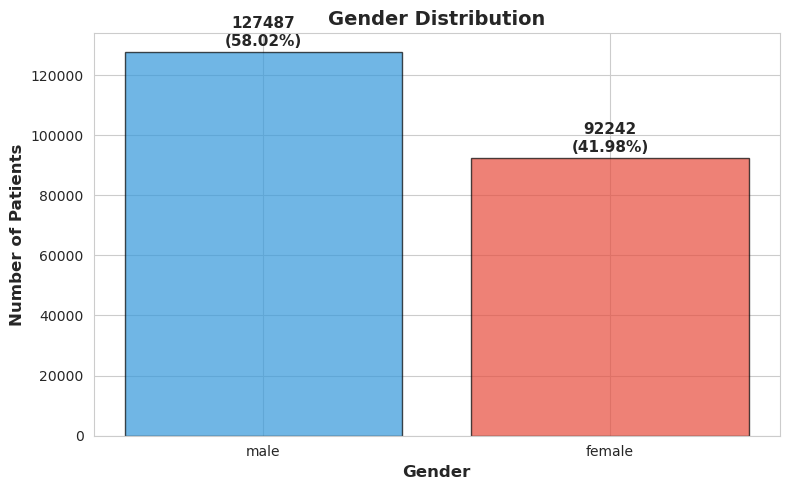

In [5]:
# Gender distribution
gender_counts = master_df['gender'].value_counts()
gender_pct = (gender_counts / len(master_df) * 100).round(2)

print("Gender Distribution:")
for gender in gender_counts.index:
    print(f"  {gender}: {gender_counts[gender]} ({gender_pct[gender]}%)")

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
bars = ax.bar(gender_counts.index, gender_counts.values, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Gender', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Add counts on top of bars
for bar, count, pct in zip(bars, gender_counts.values, gender_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(gender_counts.values)*0.01, 
            f'{count}\n({pct}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'gender_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


### 1.2 Cancer Status and Types


In [6]:
# Overall cancer vs control
cancer_counts = master_df['is_case'].value_counts()
cancer_pct = (cancer_counts / len(master_df) * 100).round(2)

print("Cancer Status Distribution:")
print(f"  Control (is_case=0): {cancer_counts.get(0, 0)} ({cancer_pct.get(0, 0)}%)")
print(f"  Cancer (is_case=1): {cancer_counts.get(1, 0)} ({cancer_pct.get(1, 0)}%)")

# Cancer types distribution (for is_case=1)
cancer_patients = master_df[master_df['is_case'] == 1]
if len(cancer_patients) > 0 and 'site' in master_df.columns:
    cancer_type_counts = cancer_patients['site'].value_counts()
    cancer_type_pct = (cancer_type_counts / len(cancer_patients) * 100).round(2)
    
    print(f"\nCancer Types (n={len(cancer_patients)}):")
    for cancer_type in cancer_type_counts.index:
        print(f"  {cancer_type}: {cancer_type_counts[cancer_type]} ({cancer_type_pct[cancer_type]}%)")
else:
    cancer_type_counts = pd.Series()
    print("\nNo cancer type information available or no cancer patients.")


Cancer Status Distribution:
  Control (is_case=0): 179453 (81.67%)
  Cancer (is_case=1): 40276 (18.33%)

Cancer Types (n=40276):
  pancreas: 14454 (35.89%)
  oesophagus: 13165 (32.69%)
  stomach: 9610 (23.86%)
  gallbladder: 3047 (7.57%)


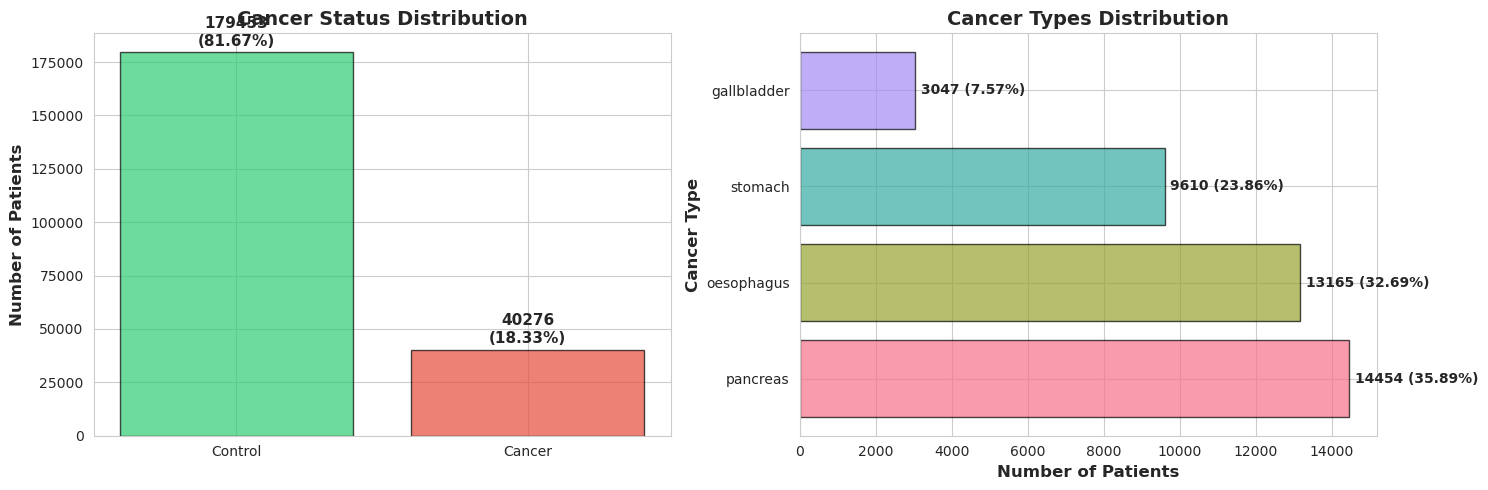

In [7]:
# Visualization: Cancer Status and Types
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall cancer vs control
ax1 = axes[0]
labels = ['Control', 'Cancer']
values = [cancer_counts.get(0, 0), cancer_counts.get(1, 0)]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax1.set_title('Cancer Status Distribution', fontsize=14, fontweight='bold')

for bar, val, pct in zip(bars, values, [cancer_pct.get(0, 0), cancer_pct.get(1, 0)]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
            f'{val}\n({pct}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Cancer types
ax2 = axes[1]
if len(cancer_type_counts) > 0:
    colors_palette = sns.color_palette("husl", len(cancer_type_counts))
    bars = ax2.barh(cancer_type_counts.index, cancer_type_counts.values, color=colors_palette, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cancer Type', fontsize=12, fontweight='bold')
    ax2.set_title('Cancer Types Distribution', fontsize=14, fontweight='bold')
    
    for bar, val, pct in zip(bars, cancer_type_counts.values, cancer_type_pct.values):
        ax2.text(val + max(cancer_type_counts.values)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{val} ({pct}%)', ha='left', va='center', fontsize=10, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'No cancer type data available', ha='center', va='center', 
            fontsize=12, transform=ax2.transAxes)
    ax2.set_xticks([])
    ax2.set_yticks([])

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'cancer_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


### 1.3 Region Distribution


Region Distribution:
  4: 5093 (2.32%)
  1: 8034 (3.66%)
  3: 8175 (3.72%)
  6: 10332 (4.7%)
  9: 27847 (12.67%)
  7: 31947 (14.54%)
  5: 38849 (17.68%)
  2: 44636 (20.31%)
  8: 44816 (20.4%)


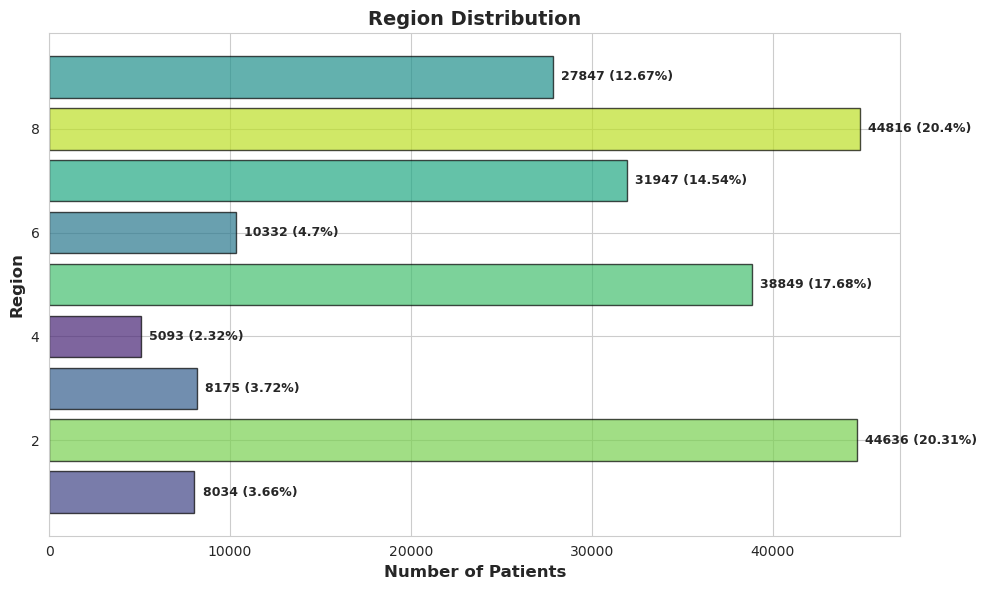

In [8]:
# Region distribution
if 'region' in master_df.columns:
    region_counts = master_df['region'].value_counts().sort_values(ascending=True)
    region_pct = (region_counts / len(master_df) * 100).round(2)
    
    print("Region Distribution:")
    for region in region_counts.index:
        print(f"  {region}: {region_counts[region]} ({region_pct[region]}%)")
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, max(6, len(region_counts) * 0.4)))
    colors_palette = sns.color_palette("viridis", len(region_counts))
    bars = ax.barh(region_counts.index, region_counts.values, color=colors_palette, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
    ax.set_ylabel('Region', fontsize=12, fontweight='bold')
    ax.set_title('Region Distribution', fontsize=14, fontweight='bold')
    
    for bar, val, pct in zip(bars, region_counts.values, region_pct.values):
        ax.text(val + max(region_counts.values)*0.01, bar.get_y() + bar.get_height()/2, 
                f'{val} ({pct}%)', ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    if OUTPUT_DIR:
        plt.savefig(os.path.join(OUTPUT_DIR, 'region_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No region information available in master CSV.")


### 1.4 Ethnicity Distribution


Ethnicity Distribution:
  White: 190174 (86.55%)
  Unknown: 13799 (6.28%)
  Indian: 2588 (1.18%)
  Other: 2423 (1.1%)
  Bl_Carib: 2173 (0.99%)
  Asian or British Asian: 1381 (0.63%)
  Oth_Asian: 1359 (0.62%)
  Bl_Afric: 1260 (0.57%)
  Pakistani: 1171 (0.53%)
  Mixed: 882 (0.4%)
  Black or Black British: 836 (0.38%)
  Bl_Other: 690 (0.31%)
  Bangladesi: 503 (0.23%)
  Chinese: 490 (0.22%)


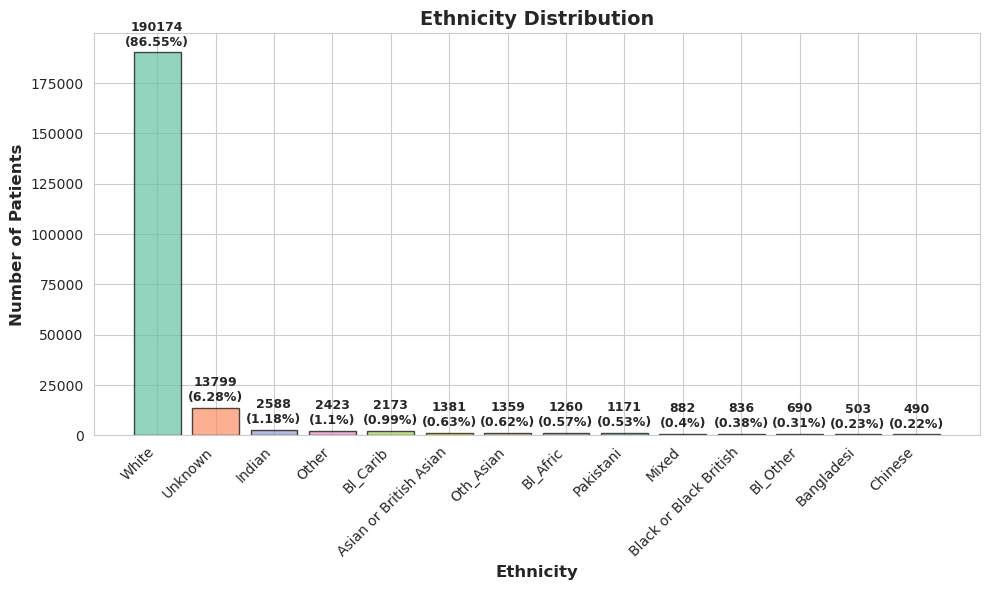

In [9]:
# Ethnicity distribution
if 'ethnicity' in master_df.columns:
    ethnicity_counts = master_df['ethnicity'].value_counts()
    ethnicity_pct = (ethnicity_counts / len(master_df) * 100).round(2)
    
    print("Ethnicity Distribution:")
    for ethnicity in ethnicity_counts.index:
        print(f"  {ethnicity}: {ethnicity_counts[ethnicity]} ({ethnicity_pct[ethnicity]}%)")
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    colors_palette = sns.color_palette("Set2", len(ethnicity_counts))
    bars = ax.bar(range(len(ethnicity_counts)), ethnicity_counts.values, color=colors_palette, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(ethnicity_counts)))
    ax.set_xticklabels(ethnicity_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
    ax.set_xlabel('Ethnicity', fontsize=12, fontweight='bold')
    ax.set_title('Ethnicity Distribution', fontsize=14, fontweight='bold')
    
    for bar, val, pct in zip(bars, ethnicity_counts.values, ethnicity_pct.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ethnicity_counts.values)*0.01, 
                f'{val}\n({pct}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    if OUTPUT_DIR:
        plt.savefig(os.path.join(OUTPUT_DIR, 'ethnicity_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No ethnicity information available in master CSV.")


### 1.5 Cross-Tabulations


In [10]:
# Cancer status by gender
print("Cancer Status by Gender:")
cancer_gender_ct = pd.crosstab(master_df['gender'], master_df['is_case'], margins=True)
cancer_gender_ct.columns = ['Control', 'Cancer', 'Total']
print(cancer_gender_ct)
print()

# Cancer status by ethnicity (if available)
if 'ethnicity' in master_df.columns:
    print("Cancer Status by Ethnicity:")
    cancer_ethnicity_ct = pd.crosstab(master_df['ethnicity'], master_df['is_case'], margins=True)
    cancer_ethnicity_ct.columns = ['Control', 'Cancer', 'Total']
    print(cancer_ethnicity_ct)
    print()

# Cancer status by region (if available)
if 'region' in master_df.columns:
    print("Cancer Status by Region:")
    cancer_region_ct = pd.crosstab(master_df['region'], master_df['is_case'], margins=True)
    cancer_region_ct.columns = ['Control', 'Cancer', 'Total']
    print(cancer_region_ct)


Cancer Status by Gender:
        Control  Cancer   Total
gender                         
female    75592   16650   92242
male     103861   23626  127487
All      179453   40276  219729

Cancer Status by Ethnicity:
                        Control  Cancer   Total
ethnicity                                      
Asian or British Asian     1379       2    1381
Bangladesi                  415      88     503
Bl_Afric                   1006     254    1260
Bl_Carib                   1648     525    2173
Bl_Other                    534     156     690
Black or Black British      832       4     836
Chinese                     393      97     490
Indian                     2245     343    2588
Mixed                       750     132     882
Oth_Asian                  1108     251    1359
Other                      2004     419    2423
Pakistani                   993     178    1171
Unknown                   12606    1193   13799
White                    153540   36634  190174
All               

## 2. Sequence Analysis (from Pickle Files)


In [11]:
# Load vocabulary to identify special tokens
print("Loading vocabulary...")
vocab_df = pd.read_csv(VOCAB_PATH)
print(f"Vocabulary size: {len(vocab_df)}")

# Identify special token IDs
special_token_ids = set()
special_token_names = ['<unknown>', '<start>', '<end>', '<event>', '</event>', '<numeric>', '</numeric>', '<text>', '</text>']
for token_name in special_token_names:
    matching_tokens = vocab_df[vocab_df['str'] == token_name]
    if len(matching_tokens) > 0:
        special_token_ids.add(matching_tokens['token'].values[0])

print(f"Special token IDs to exclude from event counts: {special_token_ids}")
vocab_df.head()


Loading vocabulary...
Vocabulary size: 2673
Special token IDs to exclude from event counts: {np.int64(0), np.int64(1), np.int64(2)}


,token,str,count
0,0,<unknown>,0
1,1,<start>,0
2,2,<end>,0
3,3,Q3,63632
4,4,Q9,61708


In [12]:
# Find all pickle files across train/tuning/held_out splits
print("Finding pickle files...")
pkl_files = []
for split in ['train', 'tuning', 'held_out']:
    split_dir = os.path.join(TOKENIZED_DATA_ROOT, split)
    if os.path.exists(split_dir):
        split_files = glob.glob(os.path.join(split_dir, "*.pkl"))
        pkl_files.extend(split_files)
        print(f"  {split}: {len(split_files)} files")
    else:
        print(f"  {split}: directory not found")

print(f"\nTotal pickle files to process: {len(pkl_files)}")


Finding pickle files...
  train: 4 files
  tuning: 4 files
  held_out: 4 files

Total pickle files to process: 12


In [13]:
# Process all pickle files and extract metrics
print("\nProcessing pickle files...")

sequence_data = []

for pkl_file in tqdm(pkl_files, desc="Loading pickle files"):
    with open(pkl_file, 'rb') as f:
        patient_list = pickle.load(f)
    
    for patient in patient_list:
        subject_id = patient['subject_id']
        tokens = patient['tokens']
        timestamps = patient['timestamps']
        
        # Calculate metrics
        sequence_length = len(tokens)
        
        # Count unique medical events (excluding special tokens)
        medical_events = [t for t in tokens if t not in special_token_ids]
        num_medical_events = len(set(medical_events))
        
        # Count unique visits (unique timestamps)
        unique_visits = len(set(timestamps))
        
        # Calculate observation period
        if len(timestamps) > 0:
            # Timestamps are strings in ISO format
            try:
                timestamp_objs = [datetime.fromisoformat(ts.replace('Z', '+00:00')) for ts in timestamps]
                obs_period_days = (max(timestamp_objs) - min(timestamp_objs)).days
                
                # Calculate time between consecutive events
                time_diffs = []
                for i in range(1, len(timestamp_objs)):
                    diff_days = (timestamp_objs[i] - timestamp_objs[i-1]).total_seconds() / 86400  # Convert to days
                    time_diffs.append(diff_days)
                
                mean_time_between_events = np.mean(time_diffs) if time_diffs else 0
                median_time_between_events = np.median(time_diffs) if time_diffs else 0
            except:
                obs_period_days = 0
                mean_time_between_events = 0
                median_time_between_events = 0
        else:
            obs_period_days = 0
            mean_time_between_events = 0
            median_time_between_events = 0
        
        sequence_data.append({
            'subject_id': subject_id,
            'sequence_length': sequence_length,
            'num_medical_events': num_medical_events,
            'unique_visits': unique_visits,
            'obs_period_days': obs_period_days,
            'mean_time_between_events': mean_time_between_events,
            'median_time_between_events': median_time_between_events
        })

# Convert to DataFrame
sequence_df = pd.DataFrame(sequence_data)
print(f"\nProcessed {len(sequence_df)} patient sequences")
sequence_df.head()



Processing pickle files...


Loading pickle files:   0%|          | 0/12 [00:00<?, ?it/s]


Processed 12000 patient sequences


,subject_id,sequence_length,num_medical_events,unique_visits,obs_period_days,mean_time_between_events,median_time_between_events
0,19551213,242,114,26,0,0,0
1,60650064,538,155,73,0,0,0
2,94851371,329,126,55,0,0,0
3,143750692,231,110,40,0,0,0
4,168850624,287,77,21,0,0,0


In [14]:
# Merge sequence data with demographics
merged_df = sequence_df.merge(master_df[['subject_id', 'is_case', 'site']], on='subject_id', how='left')

# Create cancer status labels
merged_df['cancer_status'] = merged_df['is_case'].map({0: 'Control', 1: 'Cancer'})

print(f"Merged data shape: {merged_df.shape}")
print(f"Patients with demographics info: {merged_df['is_case'].notna().sum()}")
merged_df.head()


Merged data shape: (12103, 10)
Patients with demographics info: 12103


,subject_id,sequence_length,num_medical_events,unique_visits,obs_period_days,mean_time_between_events,median_time_between_events,is_case,site,cancer_status
0,19551213,242,114,26,0,0,0,0,oesophagus,Control
1,60650064,538,155,73,0,0,0,0,oesophagus,Control
2,94851371,329,126,55,0,0,0,1,oesophagus,Cancer
3,143750692,231,110,40,0,0,0,0,oesophagus,Control
4,168850624,287,77,21,0,0,0,0,oesophagus,Control


### 2.1 Sequence Length Distribution


In [15]:
# Sequence length statistics
print("Sequence Length Statistics:")
print(f"  Mean: {merged_df['sequence_length'].mean():.2f}")
print(f"  Median: {merged_df['sequence_length'].median():.2f}")
print(f"  Min: {merged_df['sequence_length'].min()}")
print(f"  Max: {merged_df['sequence_length'].max()}")
print(f"  Std: {merged_df['sequence_length'].std():.2f}")
print(f"  Q1: {merged_df['sequence_length'].quantile(0.25):.2f}")
print(f"  Q3: {merged_df['sequence_length'].quantile(0.75):.2f}")

# By cancer status
print("\nSequence Length by Cancer Status:")
for status in ['Control', 'Cancer']:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        print(f"  {status} (n={len(subset)}):")
        print(f"    Mean: {subset['sequence_length'].mean():.2f}")
        print(f"    Median: {subset['sequence_length'].median():.2f}")


Sequence Length Statistics:
  Mean: 464.65
  Median: 388.00
  Min: 6
  Max: 12502
  Std: 442.59
  Q1: 168.00
  Q3: 651.00

Sequence Length by Cancer Status:
  Control (n=9872):
    Mean: 450.82
    Median: 376.00
  Cancer (n=2231):
    Mean: 525.82
    Median: 429.00


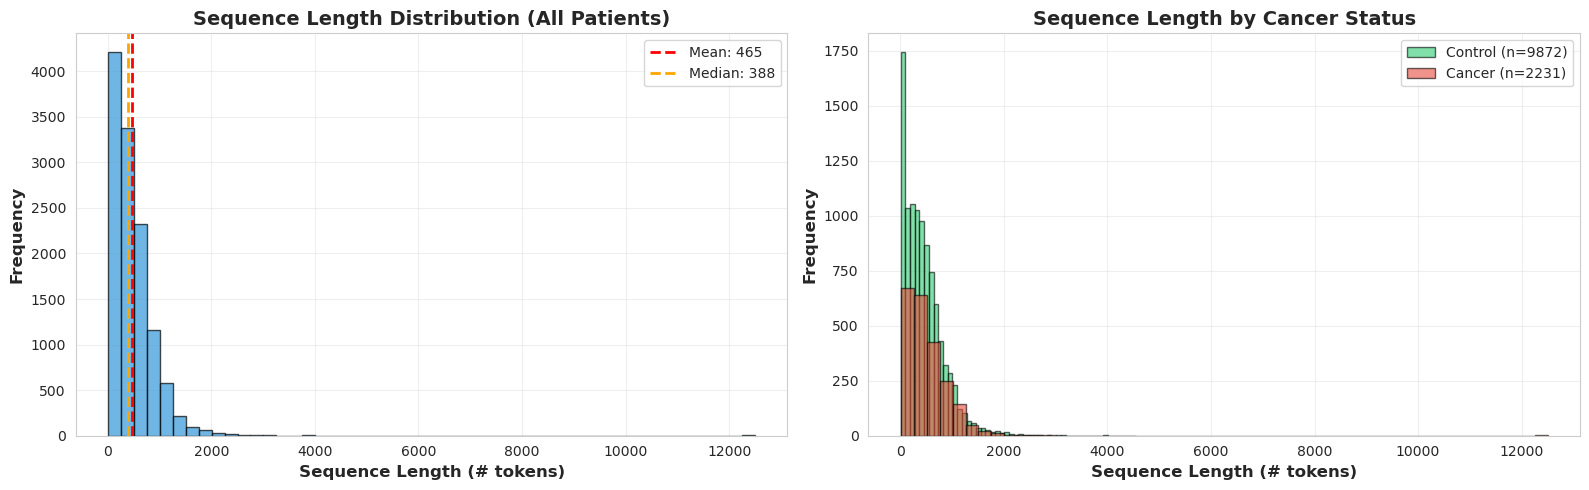

In [16]:
# Visualization: Sequence Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
ax1 = axes[0]
ax1.hist(merged_df['sequence_length'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(merged_df['sequence_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {merged_df["sequence_length"].mean():.0f}')
ax1.axvline(merged_df['sequence_length'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {merged_df["sequence_length"].median():.0f}')
ax1.set_xlabel('Sequence Length (# tokens)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Sequence Length Distribution (All Patients)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# By cancer status
ax2 = axes[1]
for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        ax2.hist(subset['sequence_length'], bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', color=color, edgecolor='black')

ax2.set_xlabel('Sequence Length (# tokens)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Sequence Length by Cancer Status', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'sequence_length_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2.2 Medical Events Analysis


In [17]:
# Medical events statistics
print("Unique Medical Events Statistics:")
print(f"  Mean: {merged_df['num_medical_events'].mean():.2f}")
print(f"  Median: {merged_df['num_medical_events'].median():.2f}")
print(f"  Min: {merged_df['num_medical_events'].min()}")
print(f"  Max: {merged_df['num_medical_events'].max()}")
print(f"  Std: {merged_df['num_medical_events'].std():.2f}")

# By cancer status
print("\nUnique Medical Events by Cancer Status:")
for status in ['Control', 'Cancer']:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        print(f"  {status} (n={len(subset)}):")
        print(f"    Mean: {subset['num_medical_events'].mean():.2f}")
        print(f"    Median: {subset['num_medical_events'].median():.2f}")


Unique Medical Events Statistics:
  Mean: 102.03
  Median: 108.00
  Min: 4
  Max: 264
  Std: 45.54

Unique Medical Events by Cancer Status:
  Control (n=9872):
    Mean: 100.86
    Median: 107.00
  Cancer (n=2231):
    Mean: 107.17
    Median: 112.00


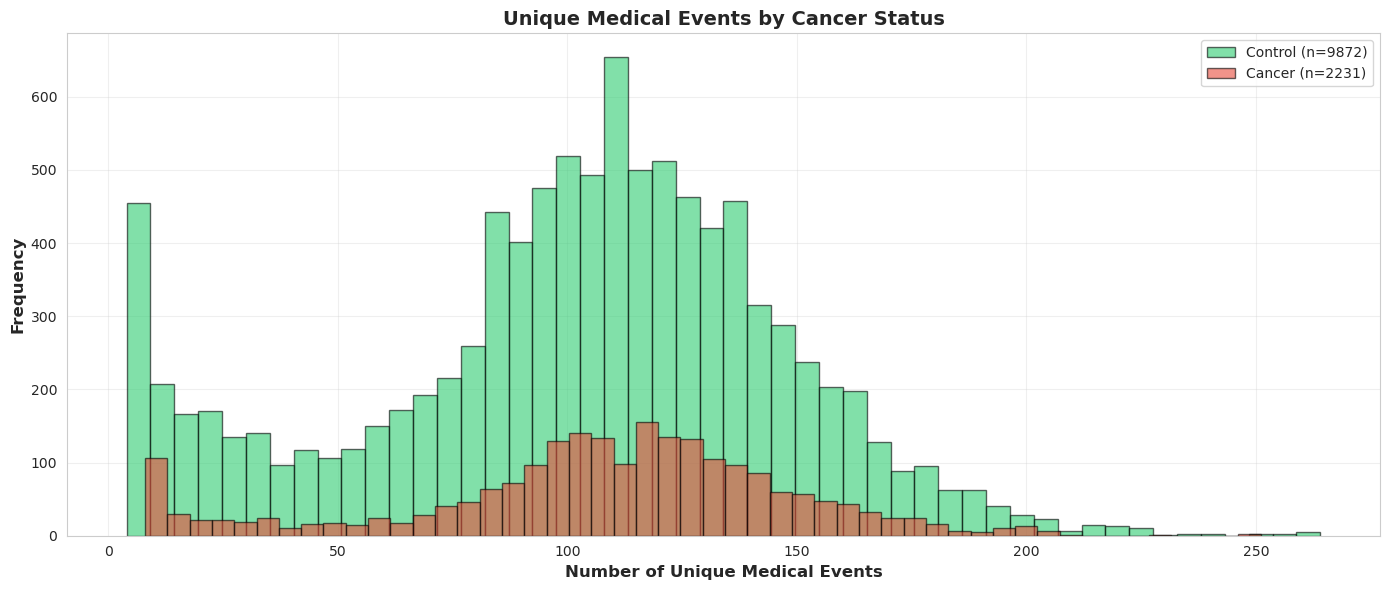

In [18]:
# Visualization: Medical Events by Cancer Status
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        ax.hist(subset['num_medical_events'], bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', color=color, edgecolor='black')

ax.set_xlabel('Number of Unique Medical Events', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Unique Medical Events by Cancer Status', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'medical_events_by_cancer.png'), dpi=300, bbox_inches='tight')
plt.show()



Unique Medical Events by Cancer Type:
  gallbladder (n=3039):
    Mean: 104.64
    Median: 110.00
  oesophagus (n=3030):
    Mean: 100.71
    Median: 106.00
  pancreas (n=3009):
    Mean: 101.54
    Median: 108.00
  stomach (n=3025):
    Mean: 101.20
    Median: 107.00


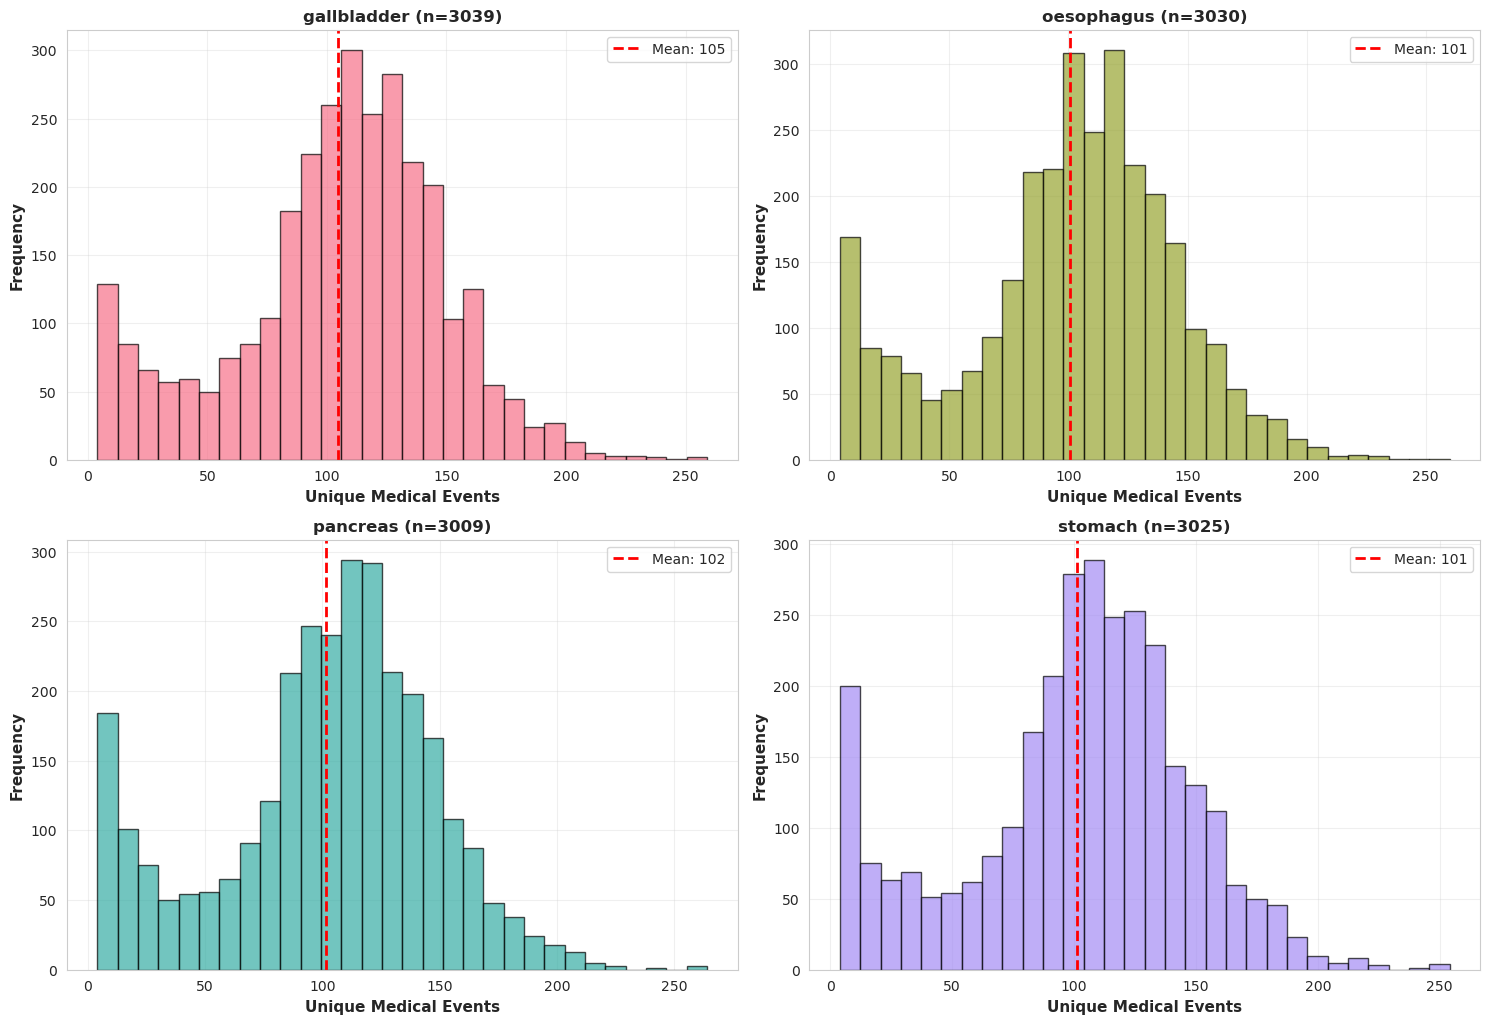

In [19]:
# Medical events by cancer type
if 'site' in merged_df.columns:
    cancer_types = merged_df[merged_df['is_case'] == 1]['site'].unique()
    
    if len(cancer_types) > 0:
        print("\nUnique Medical Events by Cancer Type:")
        for cancer_type in sorted(cancer_types):
            subset = merged_df[merged_df['site'] == cancer_type]
            if len(subset) > 0:
                print(f"  {cancer_type} (n={len(subset)}):")
                print(f"    Mean: {subset['num_medical_events'].mean():.2f}")
                print(f"    Median: {subset['num_medical_events'].median():.2f}")
        
        # Visualization for each cancer type
        n_cancer_types = len(cancer_types)
        if n_cancer_types > 1:
            fig, axes = plt.subplots(min(n_cancer_types, 3), max(1, n_cancer_types // 3 + (1 if n_cancer_types % 3 else 0)), 
                                     figsize=(15, 5 * min(n_cancer_types, 3)))
            if n_cancer_types == 1:
                axes = [axes]
            else:
                axes = axes.flatten() if n_cancer_types > 1 else [axes]
            
            colors = sns.color_palette("husl", n_cancer_types)
            
            for idx, (cancer_type, color) in enumerate(zip(sorted(cancer_types), colors)):
                if idx < len(axes):
                    subset = merged_df[merged_df['site'] == cancer_type]
                    axes[idx].hist(subset['num_medical_events'], bins=30, color=color, alpha=0.7, edgecolor='black')
                    axes[idx].axvline(subset['num_medical_events'].mean(), color='red', linestyle='--', 
                                     linewidth=2, label=f'Mean: {subset["num_medical_events"].mean():.0f}')
                    axes[idx].set_xlabel('Unique Medical Events', fontsize=11, fontweight='bold')
                    axes[idx].set_ylabel('Frequency', fontsize=11, fontweight='bold')
                    axes[idx].set_title(f'{cancer_type} (n={len(subset)})', fontsize=12, fontweight='bold')
                    axes[idx].legend()
                    axes[idx].grid(alpha=0.3)
            
            # Hide unused subplots
            for idx in range(len(cancer_types), len(axes)):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            if OUTPUT_DIR:
                plt.savefig(os.path.join(OUTPUT_DIR, 'medical_events_by_cancer_type.png'), dpi=300, bbox_inches='tight')
            plt.show()


### 2.3 Visit Analysis


In [20]:
# Visit statistics
print("Unique Visits Statistics:")
print(f"  Mean: {merged_df['unique_visits'].mean():.2f}")
print(f"  Median: {merged_df['unique_visits'].median():.2f}")
print(f"  Min: {merged_df['unique_visits'].min()}")
print(f"  Max: {merged_df['unique_visits'].max()}")

# Patients with < 5 unique visits
few_visits = merged_df[merged_df['unique_visits'] < 5]
print(f"\nPatients with < 5 unique visits: {len(few_visits)} ({len(few_visits)/len(merged_df)*100:.2f}%)")

# By cancer status
print("\nUnique Visits by Cancer Status:")
for status in ['Control', 'Cancer']:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        few_subset = subset[subset['unique_visits'] < 5]
        print(f"  {status} (n={len(subset)}):")
        print(f"    Mean visits: {subset['unique_visits'].mean():.2f}")
        print(f"    Median visits: {subset['unique_visits'].median():.2f}")
        print(f"    < 5 visits: {len(few_subset)} ({len(few_subset)/len(subset)*100:.2f}%)")


Unique Visits Statistics:
  Mean: 53.97
  Median: 45.00
  Min: 2
  Max: 538

Patients with < 5 unique visits: 702 (5.80%)

Unique Visits by Cancer Status:
  Control (n=9872):
    Mean visits: 52.88
    Median visits: 44.00
    < 5 visits: 593 (6.01%)
  Cancer (n=2231):
    Mean visits: 58.82
    Median visits: 48.00
    < 5 visits: 109 (4.89%)


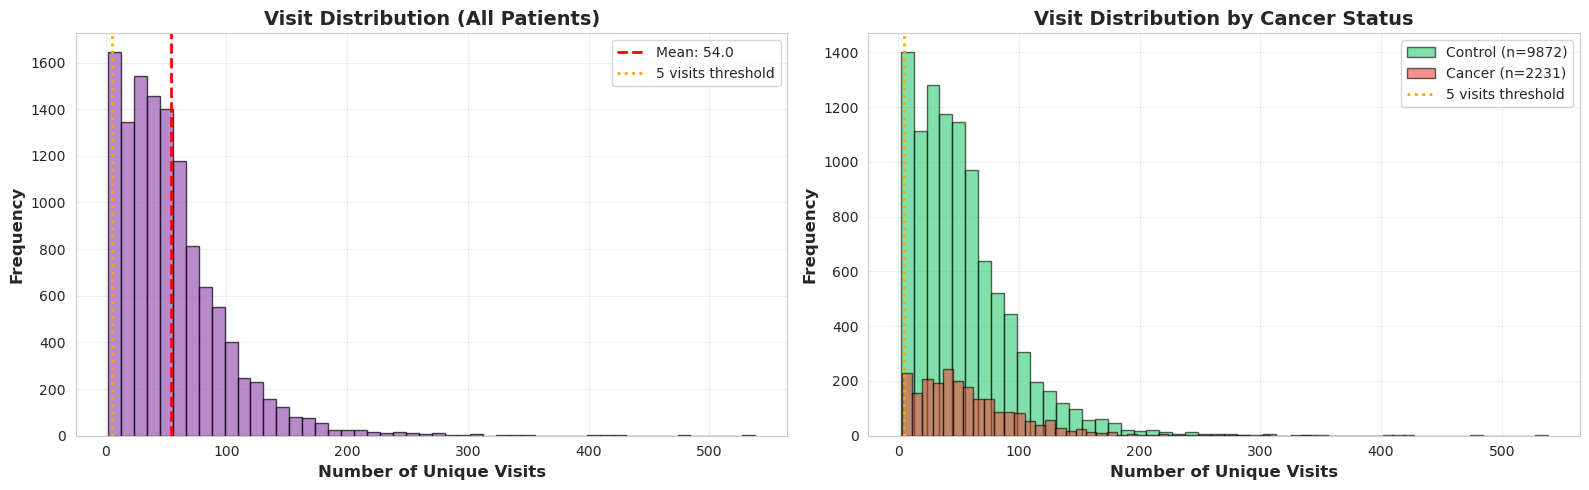

In [21]:
# Visualization: Visit Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
ax1 = axes[0]
ax1.hist(merged_df['unique_visits'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax1.axvline(merged_df['unique_visits'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {merged_df["unique_visits"].mean():.1f}')
ax1.axvline(5, color='orange', linestyle=':', linewidth=2, label='5 visits threshold')
ax1.set_xlabel('Number of Unique Visits', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Visit Distribution (All Patients)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# By cancer status
ax2 = axes[1]
for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        ax2.hist(subset['unique_visits'], bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', 
                color=color, edgecolor='black')

ax2.axvline(5, color='orange', linestyle=':', linewidth=2, label='5 visits threshold')
ax2.set_xlabel('Number of Unique Visits', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Visit Distribution by Cancer Status', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'visit_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2.4 Observation Period


In [22]:
# Observation period statistics (in years)
merged_df['obs_period_years'] = merged_df['obs_period_days'] / 365.25

print("Observation Period Statistics:")
print(f"  Mean: {merged_df['obs_period_years'].mean():.2f} years ({merged_df['obs_period_days'].mean():.1f} days)")
print(f"  Median: {merged_df['obs_period_years'].median():.2f} years ({merged_df['obs_period_days'].median():.1f} days)")
print(f"  Min: {merged_df['obs_period_years'].min():.2f} years ({merged_df['obs_period_days'].min():.1f} days)")
print(f"  Max: {merged_df['obs_period_years'].max():.2f} years ({merged_df['obs_period_days'].max():.1f} days)")

# By cancer status
print("\nObservation Period by Cancer Status:")
for status in ['Control', 'Cancer']:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        print(f"  {status} (n={len(subset)}):")
        print(f"    Mean: {subset['obs_period_years'].mean():.2f} years")
        print(f"    Median: {subset['obs_period_years'].median():.2f} years")


Observation Period Statistics:
  Mean: 0.00 years (0.0 days)
  Median: 0.00 years (0.0 days)
  Min: 0.00 years (0.0 days)
  Max: 0.00 years (0.0 days)

Observation Period by Cancer Status:
  Control (n=9872):
    Mean: 0.00 years
    Median: 0.00 years
  Cancer (n=2231):
    Mean: 0.00 years
    Median: 0.00 years


In [ ]:
# Visualization: Observation Period
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
ax1 = axes[0]
ax1.hist(merged_df['obs_period_years'], bins=50, color='#1abc9c', alpha=0.7, edgecolor='black')
ax1.axvline(merged_df['obs_period_years'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {merged_df["obs_period_years"].mean():.1f} years')
ax1.axvline(merged_df['obs_period_years'].median(), color='orange', linestyle='--', linewidth=2, 
           label=f'Median: {merged_df["obs_period_years"].median():.1f} years')
ax1.set_xlabel('Observation Period (years)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Observation Period Distribution (All Patients)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# By cancer status
ax2 = axes[1]
for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        ax2.hist(subset['obs_period_years'], bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', 
                color=color, edgecolor='black')

ax2.set_xlabel('Observation Period (years)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Observation Period by Cancer Status', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'observation_period.png'), dpi=300, bbox_inches='tight')
plt.show()


### 2.5 Time Between Events


In [23]:
# Time between events statistics
print("Mean Time Between Events Statistics:")
print(f"  Mean: {merged_df['mean_time_between_events'].mean():.2f} days")
print(f"  Median: {merged_df['mean_time_between_events'].median():.2f} days")
print(f"  Min: {merged_df['mean_time_between_events'].min():.2f} days")
print(f"  Max: {merged_df['mean_time_between_events'].max():.2f} days")

print("\nMedian Time Between Events Statistics:")
print(f"  Mean: {merged_df['median_time_between_events'].mean():.2f} days")
print(f"  Median: {merged_df['median_time_between_events'].median():.2f} days")

# By cancer status
print("\nMean Time Between Events by Cancer Status:")
for status in ['Control', 'Cancer']:
    subset = merged_df[merged_df['cancer_status'] == status]
    if len(subset) > 0:
        print(f"  {status} (n={len(subset)}):")
        print(f"    Mean of means: {subset['mean_time_between_events'].mean():.2f} days")
        print(f"    Mean of medians: {subset['median_time_between_events'].mean():.2f} days")


Mean Time Between Events Statistics:
  Mean: 0.00 days
  Median: 0.00 days
  Min: 0.00 days
  Max: 0.00 days

Median Time Between Events Statistics:
  Mean: 0.00 days
  Median: 0.00 days

Mean Time Between Events by Cancer Status:
  Control (n=9872):
    Mean of means: 0.00 days
    Mean of medians: 0.00 days
  Cancer (n=2231):
    Mean of means: 0.00 days
    Mean of medians: 0.00 days


In [ ]:
# Visualization: Time Between Events
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Mean time between events - overall
ax1 = axes[0, 0]
# Use log scale for better visualization if needed
data_to_plot = merged_df['mean_time_between_events'][merged_df['mean_time_between_events'] > 0]
ax1.hist(data_to_plot, bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
ax1.axvline(data_to_plot.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {data_to_plot.mean():.1f} days')
ax1.set_xlabel('Mean Time Between Events (days)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Mean Time Between Events (All Patients)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Mean time between events - by cancer status
ax2 = axes[0, 1]
for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    subset_data = subset['mean_time_between_events'][subset['mean_time_between_events'] > 0]
    if len(subset_data) > 0:
        ax2.hist(subset_data, bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', 
                color=color, edgecolor='black')

ax2.set_xlabel('Mean Time Between Events (days)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Mean Time Between Events by Cancer Status', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Median time between events - overall
ax3 = axes[1, 0]
data_to_plot = merged_df['median_time_between_events'][merged_df['median_time_between_events'] > 0]
ax3.hist(data_to_plot, bins=50, color='#8e44ad', alpha=0.7, edgecolor='black')
ax3.axvline(data_to_plot.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {data_to_plot.mean():.1f} days')
ax3.set_xlabel('Median Time Between Events (days)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Median Time Between Events (All Patients)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Median time between events - by cancer status
ax4 = axes[1, 1]
for status, color in [('Control', '#2ecc71'), ('Cancer', '#e74c3c')]:
    subset = merged_df[merged_df['cancer_status'] == status]
    subset_data = subset['median_time_between_events'][subset['median_time_between_events'] > 0]
    if len(subset_data) > 0:
        ax4.hist(subset_data, bins=50, alpha=0.6, label=f'{status} (n={len(subset)})', 
                color=color, edgecolor='black')

ax4.set_xlabel('Median Time Between Events (days)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Median Time Between Events by Cancer Status', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
if OUTPUT_DIR:
    plt.savefig(os.path.join(OUTPUT_DIR, 'time_between_events.png'), dpi=300, bbox_inches='tight')
plt.show()


## 3. Summary Statistics


In [ ]:
# Create comprehensive summary table
summary_stats = []

# Overall statistics
summary_stats.append({
    'Metric': 'Total Patients',
    'Value': f"{len(merged_df)}"
})

summary_stats.append({
    'Metric': 'Control Patients',
    'Value': f"{len(merged_df[merged_df['is_case']==0])} ({len(merged_df[merged_df['is_case']==0])/len(merged_df)*100:.1f}%)"
})

summary_stats.append({
    'Metric': 'Cancer Patients',
    'Value': f"{len(merged_df[merged_df['is_case']==1])} ({len(merged_df[merged_df['is_case']==1])/len(merged_df)*100:.1f}%)"
})

# Cancer types
if 'site' in merged_df.columns:
    cancer_patients = merged_df[merged_df['is_case'] == 1]
    if len(cancer_patients) > 0:
        cancer_types = cancer_patients['site'].value_counts()
        for cancer_type, count in cancer_types.items():
            summary_stats.append({
                'Metric': f"  - {cancer_type}",
                'Value': f"{count} ({count/len(cancer_patients)*100:.1f}%)"
            })

# Sequence statistics
summary_stats.append({
    'Metric': 'Average Sequence Length',
    'Value': f"{merged_df['sequence_length'].mean():.1f} ± {merged_df['sequence_length'].std():.1f}"
})

summary_stats.append({
    'Metric': 'Median Sequence Length',
    'Value': f"{merged_df['sequence_length'].median():.1f}"
})

summary_stats.append({
    'Metric': 'Average Unique Medical Events',
    'Value': f"{merged_df['num_medical_events'].mean():.1f} ± {merged_df['num_medical_events'].std():.1f}"
})

summary_stats.append({
    'Metric': 'Average Unique Visits',
    'Value': f"{merged_df['unique_visits'].mean():.1f} ± {merged_df['unique_visits'].std():.1f}"
})

summary_stats.append({
    'Metric': 'Patients with < 5 Visits',
    'Value': f"{len(merged_df[merged_df['unique_visits'] < 5])} ({len(merged_df[merged_df['unique_visits'] < 5])/len(merged_df)*100:.1f}%)"
})

summary_stats.append({
    'Metric': 'Average Observation Period',
    'Value': f"{merged_df['obs_period_years'].mean():.2f} years ({merged_df['obs_period_days'].mean():.0f} days)"
})

summary_stats.append({
    'Metric': 'Median Observation Period',
    'Value': f"{merged_df['obs_period_years'].median():.2f} years ({merged_df['obs_period_days'].median():.0f} days)"
})

summary_stats.append({
    'Metric': 'Mean Time Between Events',
    'Value': f"{merged_df['mean_time_between_events'].mean():.2f} days"
})

# Create DataFrame
summary_df = pd.DataFrame(summary_stats)

print("\n" + "="*70)
print("DATASET SUMMARY STATISTICS")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)


In [ ]:
# Create a detailed comparison table: Cancer vs Control
comparison_stats = []

for metric, column in [
    ('Sequence Length', 'sequence_length'),
    ('Unique Medical Events', 'num_medical_events'),
    ('Unique Visits', 'unique_visits'),
    ('Observation Period (years)', 'obs_period_years'),
    ('Mean Time Between Events (days)', 'mean_time_between_events')
]:
    control = merged_df[merged_df['is_case'] == 0][column]
    cancer = merged_df[merged_df['is_case'] == 1][column]
    
    comparison_stats.append({
        'Metric': metric,
        'Control Mean': f"{control.mean():.2f}",
        'Control Median': f"{control.median():.2f}",
        'Cancer Mean': f"{cancer.mean():.2f}",
        'Cancer Median': f"{cancer.median():.2f}"
    })

comparison_df = pd.DataFrame(comparison_stats)

print("\n" + "="*100)
print("CANCER vs CONTROL COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


## 4. Export Summary Tables (Optional)


In [ ]:
# Optionally export summary tables to CSV
if OUTPUT_DIR:
    summary_df.to_csv(os.path.join(OUTPUT_DIR, 'dataset_summary.csv'), index=False)
    comparison_df.to_csv(os.path.join(OUTPUT_DIR, 'cancer_vs_control_comparison.csv'), index=False)
    print(f"Summary tables exported to {OUTPUT_DIR}")
else:
    print("OUTPUT_DIR not set. To export summary tables, set OUTPUT_DIR to a directory path.")


---
## Analysis Complete!

This notebook has analyzed:
- **Demographics**: Gender, cancer status, cancer types, region, and ethnicity distributions
- **Sequence Characteristics**: Sequence length, unique medical events, visits, observation period, and time between events
- **Cancer vs Control Comparisons**: All metrics compared between cancer and control patients

All visualizations have been generated and summary statistics tables have been created.
